In [1]:
import pandas as pd
import numpy as np
import statsmodels.tsa.api as smt     
#tsa为Time Series analysis缩写
import statsmodels.api as sm
import scipy.stats as scs
from arch import arch_model
#画图
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
#正常显示画图时出现的中文和负号
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
mpl.rcParams['axes.unicode_minus']=False

In [3]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller as ADF
from statsmodels.stats.diagnostic import acorr_ljungbox

In [86]:
#获取数据
df=pd.read_excel('data.xls',encoding='utf-8', index_col='Time')
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 20472 entries, 2014-09-01 00:00:00 to 2016-12-31 23:00:00
Data columns (total 6 columns):
y    20472 non-null float64
p    20472 non-null float64
r    20472 non-null float64
t    20472 non-null float64
u    20472 non-null float64
v    20472 non-null float64
dtypes: float64(6)
memory usage: 1.1 MB


In [87]:
df.head()

,y,p,r,t,u,v
Time,,,,,,
2014-09-01 00:00:00,15.78,16.80,0.319399,298.288483,2.694659,1.392477
2014-09-01 01:00:00,32.18,35.20,0.319399,298.288483,2.694659,1.392477
2014-09-01 02:00:00,32.82,36.50,0.319399,299.756348,4.015072,0.340476
2014-09-01 03:00:00,31.71,36.20,0.319399,301.224182,4.981209,-0.667879
2014-09-01 04:00:00,34.41,39.89,0.714590,301.851410,5.261214,-0.924223


In [103]:
def stability_test(data):
    diff=0
    adf=ADF(data)
    while adf[1]>=0.05:   
        #h0:存在单位根，序列不平稳
        diff+=1
        adf=ADF(data.diff(diff).dropna())
    return diff,adf[1]
    #print('经过%d阶差分平稳，此时p值为%f'%(diff,adf[1]))

In [104]:
#判断数据经过多少阶平稳
for c in df.columns:
    a,b=stability_test(df[c])
    print(f'数据{c}经过{a}阶差分平稳，此时p值为{b}')

数据y经过0阶差分平稳，此时p值为6.455222578477926e-24
数据p经过0阶差分平稳，此时p值为7.90487206122786e-30
数据r经过0阶差分平稳，此时p值为7.472052727036412e-30
数据t经过0阶差分平稳，此时p值为0.00060691845759482
数据u经过0阶差分平稳，此时p值为3.0343709817083926e-28
数据v经过0阶差分平稳，此时p值为1.4462413741835467e-28


In [106]:
#序列白噪声检验
def jungbox_test(data):
    [[lb],p]=acorr_ljungbox(data,lags=1) 
    if p<0.05:  #h0序列是白噪声序列
        print('原序列是非白噪声序列，此时p值为%f'%p)
    else :
        print('原序列是白噪声序列，此时p值为%f'%p)
    [[lb],p]=acorr_ljungbox(data.diff().dropna(),lags=1) 
    if p<0.05:  #h0序列是白噪声序列
        print('一阶差分序列是非白噪声序列，此时p值为%f'%p)
    else :
        print('一阶差分序列是白噪声序列，此时p值为%f'%p)

In [108]:
for c in df.columns:
    print(f'数据{c}')
    jungbox_test(df[c])
    print()

数据y
原序列是非白噪声序列，此时p值为0.000000
一阶差分序列是非白噪声序列，此时p值为0.000000

数据p
原序列是非白噪声序列，此时p值为0.000000
一阶差分序列是非白噪声序列，此时p值为0.000000

数据r
原序列是非白噪声序列，此时p值为0.000000
一阶差分序列是白噪声序列，此时p值为1.000000

数据t
原序列是非白噪声序列，此时p值为0.000000
一阶差分序列是非白噪声序列，此时p值为0.000000

数据u
原序列是非白噪声序列，此时p值为0.000000
一阶差分序列是非白噪声序列，此时p值为0.000000

数据v
原序列是非白噪声序列，此时p值为0.000000
一阶差分序列是非白噪声序列，此时p值为0.000000



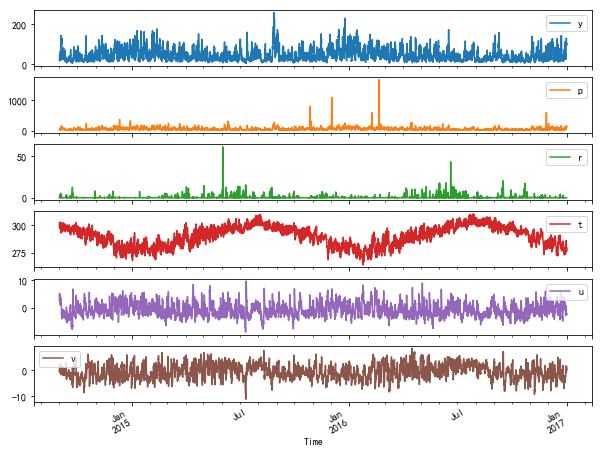

In [113]:
df.plot(subplots=True,figsize=(10,8))
plt.show()

In [119]:
def ts_plot(data, lags=None,title=''):
    if not isinstance(data, pd.Series):   
        data = pd.Series(data)
    #matplotlib官方提供了五种不同的图形风格，
    #包括bmh、ggplot、dark_background、fivethirtyeight和grayscale
    with plt.style.context('ggplot'):    
        fig = plt.figure(figsize=(10, 8))
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))

        data.plot(ax=ts_ax)
        ts_ax.set_title(title+'时序图')
        smt.graphics.plot_acf(data, lags=lags, ax=acf_ax, alpha=0.5)
        acf_ax.set_title('自相关系数')
        smt.graphics.plot_pacf(data, lags=lags, ax=pacf_ax, alpha=0.5)
        pacf_ax.set_title('偏自相关系数')
        sm.qqplot(data, line='s', ax=qq_ax)
        qq_ax.set_title('QQ 图')        
        scs.probplot(data, sparams=(data.mean(), data.std()), plot=pp_ax)
        pp_ax.set_title('PP 图') 
        plt.tight_layout()
    return

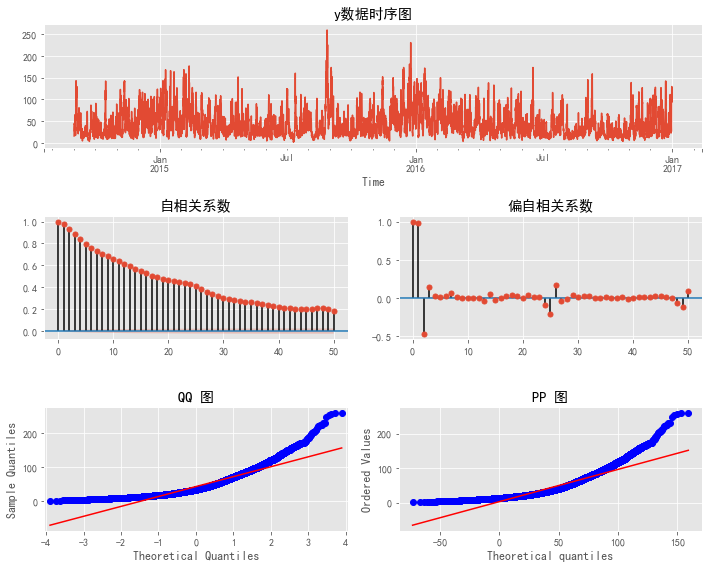

In [125]:
ts_plot(df.y, lags=50,title='y数据')

In [114]:
#确定模型阶数
import warnings
warnings.filterwarnings("ignore")
def model_pq(data,pmax=5,qmax=5,d=0):
    bic_matrix=[]
    for p in range(pmax):    
        tmp=[]
        for q in range(qmax):  
            try :
                tmp.append(ARIMA(data,(p,d,q)).fit().bic)
            except :
                tmp.append(None)
        bic_matrix.append(tmp)  
    bic_matrix=pd.DataFrame(bic_matrix)
    p,q=bic_matrix.stack().idxmin()   
    return p,q

In [156]:
n=24*30
ts=df.y[:n]
p,q=model_pq(ts)
print(p,q)
arima=ARIMA(ts,(p,0,q)).fit()
xdata_pred=arima.predict()
pred_error=(xdata_pred-ts[1:]).dropna()

1 2


In [155]:
arima.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                      y   No. Observations:                  720
Model:                     ARMA(1, 2)   Log Likelihood               -2119.562
Method:                       css-mle   S.D. of innovations              4.583
Date:                Tue, 17 Sep 2019   AIC                           4249.123
Time:                        22:09:38   BIC                           4272.019
Sample:                    09-01-2014   HQIC                          4257.962
                         - 09-30-2014                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         34.0232      6.172      5.513      0.000      21.927      46.119
ar.L1.y        0.9584      0.011     88.011      0.000       0.937       0.980
ma.L1.y        0.3426      0.038      9.056      0.000       0.268       0.417
ma.L2.y        0.2053      0.038      5.380      0.000       0.131       0.280
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0434           +0.0000j            1.0434            0.0000
MA.1           -0.8343           -2.0432j            2.2069           -0.3117
MA.2           -0.8343           +2.0432j            2.2069            0.3117
-----------------------------------------------------------------------------
"""

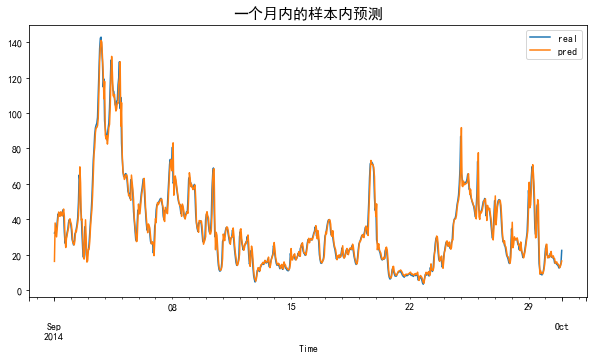

In [160]:
df_p=pd.DataFrame()
df_p['real']=ts[1:]
df_p['pred']=xdata_pred
df_p.plot(figsize=(10,5))
plt.title('一个月内的样本内预测',size=15)
plt.show()

In [37]:
arima=ARIMA(xdata,(p,1,q)).fit()
xdata_pred=arima.predict(typ='levels')
pred_error=(xdata_pred-xdata[1:]).dropna()
#arima.resid  # 残差

In [127]:
[lb],p=acorr_ljungbox(pred_error,lags=1) 
#LB时间序列是否存在滞后相关的一种统计检验，选一阶滞后
if p<0.05: 
    # 即拒绝原假设，h0是白噪声序列
    print('残差序列不是白噪声序列，p值为%f'%p)
else:
    print('残差序列是白噪声序列，p值为%f'%p)

残差序列是白噪声序列，p值为0.935718


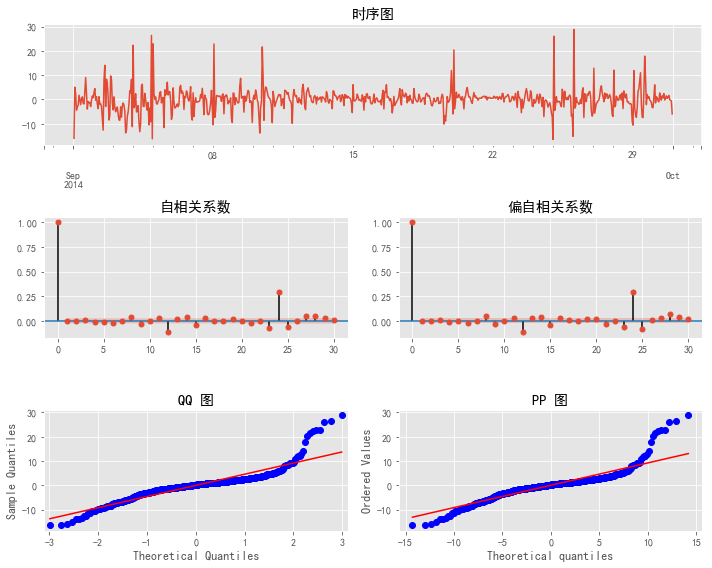

In [134]:
ts_resid=pred_error
ts_plot(ts_resid, lags=30)

In [147]:
start=df.y.index[n]
end=df.y.index[2*n]
start,end

(Timestamp('2014-10-01 00:00:00'), Timestamp('2014-10-31 00:00:00'))

In [149]:
arima.predict(start,end,dynamic=True)

2014-10-01 00:00:00    25.004306
2014-10-01 01:00:00    26.606655
2014-10-01 02:00:00    26.914813
2014-10-01 03:00:00    27.210168
2014-10-01 04:00:00    27.493251
2014-10-01 05:00:00    27.764571
2014-10-01 06:00:00    28.024618
2014-10-01 07:00:00    28.273860
2014-10-01 08:00:00    28.512745
2014-10-01 09:00:00    28.741705
2014-10-01 10:00:00    28.961152
2014-10-01 11:00:00    29.171480
2014-10-01 12:00:00    29.373069
2014-10-01 13:00:00    29.566282
2014-10-01 14:00:00    29.751467
2014-10-01 15:00:00    29.928958
2014-10-01 16:00:00    30.099073
2014-10-01 17:00:00    30.262121
2014-10-01 18:00:00    30.418393
2014-10-01 19:00:00    30.568173
2014-10-01 20:00:00    30.711729
2014-10-01 21:00:00    30.849320
2014-10-01 22:00:00    30.981194
2014-10-01 23:00:00    31.107589
2014-10-02 00:00:00    31.228732
2014-10-02 01:00:00    31.344841
2014-10-02 02:00:00    31.456126
2014-10-02 03:00:00    31.562787
2014-10-02 04:00:00    31.665017
2014-10-02 05:00:00    31.762998
          

平均绝对误差MAE=15.700600；
均方根误差RMSE=20.373026；
平均绝对百分比误差MAPE=0.737013。


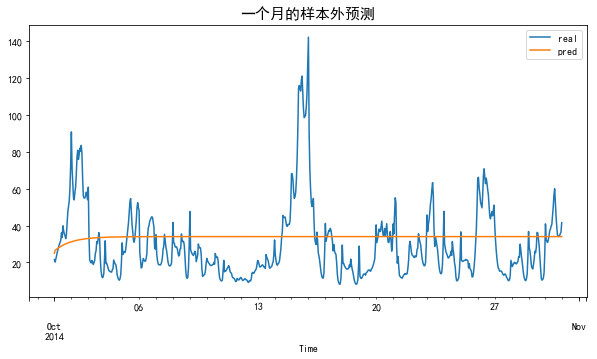

In [161]:
df_0=pd.DataFrame()
df_0['real']=df.y[n:2*n]
df_0['pred']=arima.predict(start,end,dynamic=True)

abs_=(df_0['real']-df_0['pred']).abs()
mae=abs_.mean()#Mean Absolute Error ，平均绝对误差
rmse=((abs_**2).mean())**0.5 #Root Mean Square Error,均方根误差
mape=(abs_/df_0['real']).mean()# mean absolute percentage error，平均绝对百分比误差
print('平均绝对误差MAE=%f；\n均方根误差RMSE=%f；\n平均绝对百分比误差MAPE=%f。'%(mae,rmse,mape))
df_0.plot(figsize=(10,5))
plt.title('一个月的样本外预测',size=15)
plt.show()

bic: -1148.5960437008573 p: 0 q: 1
[-0.00033763]
-0.0003308343046171796


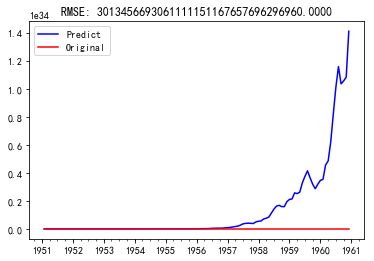

In [82]:
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARMA
import sys
from dateutil.relativedelta import relativedelta
from copy import deepcopy
import matplotlib.pyplot as plt

class arima_model:

    def __init__(self, ts, maxLag=9):
        self.data_ts = ts
        self.resid_ts = None
        self.predict_ts = None
        self.maxLag = maxLag
        self.p = maxLag
        self.q = maxLag
        self.properModel = None
        self.bic = sys.maxsize

    # 计算最优ARIMA模型，将相关结果赋给相应属性
    def get_proper_model(self):
        self._proper_model()
        self.predict_ts = deepcopy(self.properModel.predict())
        self.resid_ts = deepcopy(self.properModel.resid)

    # 对于给定范围内的p,q计算拟合得最好的arima模型，这里是对差分好的数据进行拟合，故差分恒为0
    def _proper_model(self):
        for p in np.arange(self.maxLag):
            for q in np.arange(self.maxLag):
                # print p,q,self.bic
                model = ARMA(self.data_ts, order=(p, q))
                try:
                    results_ARMA = model.fit(disp=-1, method='css')
                except:
                    continue
                bic = results_ARMA.bic
                # print 'bic:',bic,'self.bic:',self.bic
                if bic < self.bic:
                    self.p = p
                    self.q = q
                    self.properModel = results_ARMA
                    self.bic = bic
                    self.resid_ts = deepcopy(self.properModel.resid)
                    self.predict_ts = self.properModel.predict()

    # 参数确定模型
    def certain_model(self, p, q):
            model = ARMA(self.data_ts, order=(p, q))
            try:
                self.properModel = model.fit( disp=-1, method='css')
                self.p = p
                self.q = q
                self.bic = self.properModel.bic
                self.predict_ts = self.properModel.predict()
                self.resid_ts = deepcopy(self.properModel.resid)
            except:
                print ('You can not fit the model with this parameter p,q, ' \
                      'please use the get_proper_model method to get the best model')

    # 预测第二日的值
    def forecast_next_day_value(self, type='day'):
        # 我修改了statsmodels包中arima_model的源代码，添加了constant属性，
        #需要先运行forecast方法，为constant赋值
        self.properModel.forecast()
        if self.data_ts.index[-1] != self.resid_ts.index[-1]:
            raise ValueError('''The index is different in data_ts and resid_ts, please add new data to data_ts.
            If you just want to forecast the next day data without add the real next day data to data_ts,
            please run the predict method which arima_model included itself''')
        if not self.properModel:
            raise ValueError('The arima model have not computed, please run the proper_model method before')
        para = self.properModel.params

        # print self.properModel.params
        if self.p == 0:   
            # It will get all the value series with setting self.data_ts[-self.p:] when p is zero
            ma_value = self.resid_ts[-self.q:]
            values = ma_value.reindex(index=ma_value.index[::-1])
        elif self.q == 0:
            ar_value = self.data_ts[-self.p:]
            values = ar_value.reindex(index=ar_value.index[::-1])
        else:
            ar_value = self.data_ts[-self.p:]
            ar_value = ar_value.reindex(index=ar_value.index[::-1])
            ma_value = self.resid_ts[-self.q:]
            ma_value = ma_value.reindex(index=ma_value.index[::-1])
            values = ar_value.append(ma_value)

        predict_value = np.dot(para[1:], values) 
        self._add_new_data(self.predict_ts, predict_value, type)
        return predict_value

    # 动态添加数据函数，针对索引是月份和日分别进行处理
    def _add_new_data(self, ts, dat, type='day'):
        if type == 'day':
            new_index = ts.index[-1] + relativedelta(days=1)
        elif type == 'month':
            new_index = ts.index[-1] + relativedelta(months=1)
        ts[new_index] = dat

    def add_today_data(self, dat, type='day'):
        self._add_new_data(self.data_ts, dat, type)
        if self.data_ts.index[-1] != self.predict_ts.index[-1]:
            raise ValueError('You must use the forecast_next_day_value method forecast the value of today before')
        self._add_new_data(self.resid_ts, self.data_ts[-1] - self.predict_ts[-1], type)

if __name__ == '__main__':
    df = pd.read_csv('AirPassengers.csv', encoding='utf-8', index_col='Month')
    df.index = pd.to_datetime(df.index)
    ts = df['#Passengers']

    # 数据预处理
    ts_log = np.log(ts)
    rol_mean = ts_log.rolling(window=24).mean()
    rol_mean.dropna(inplace=True)
    ts_diff_1 = rol_mean.diff(1)
    ts_diff_1.dropna(inplace=True)
    ts_diff_2 = ts_diff_1.diff(1)
    ts_diff_2.dropna(inplace=True)

    # 模型拟合
    model = arima_model(ts_diff_2)
    #  这里使用模型参数自动识别
    model.get_proper_model()
    print ('bic:', model.bic, 'p:', model.p, 'q:', model.q)
    print (model.properModel.forecast()[0])
    print (model.forecast_next_day_value(type='month'))

    # 预测结果还原
    predict_ts = model.properModel.predict()
    diff_shift_ts = ts_diff_1.shift(1)
    diff_recover_1 = predict_ts.add(diff_shift_ts)
    rol_shift_ts = rol_mean.shift(1)
    diff_recover = diff_recover_1.add(rol_shift_ts)
    rol_sum = ts_log.rolling(window=11).sum()
    rol_recover = diff_recover*24 - rol_sum.shift(1)
    log_recover = np.exp(rol_recover)
    log_recover.dropna(inplace=True)

    # 预测结果作图
    ts = ts[log_recover.index]
    plt.figure(facecolor='white')
    log_recover.plot(color='blue', label='Predict')
    ts.plot(color='red', label='Original')
    plt.legend(loc='best')
    plt.title('RMSE: %.4f'% np.sqrt(sum((log_recover-ts)**2)/ts.size))
    plt.show()